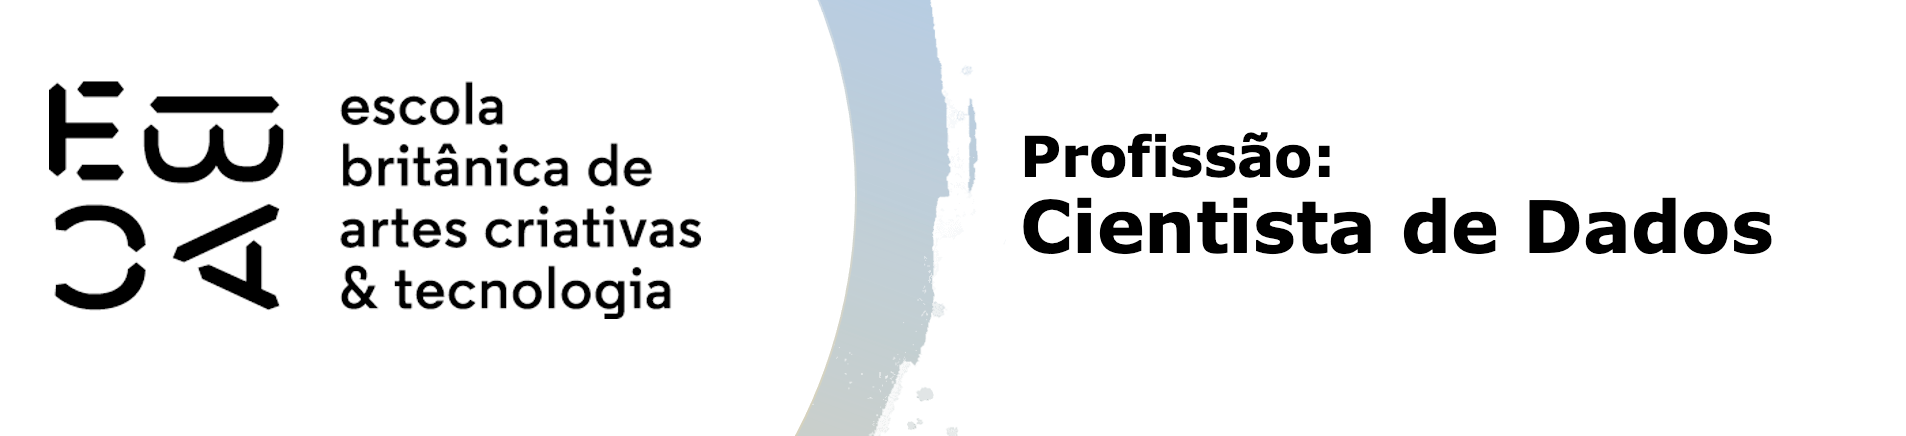

# Tarefa II

Neste projeto, estamos construindo um credit scoring para cartão de crédito, em um desenho amostral com 15 safras, e utilizando 12 meses de performance.

Carregue a base de dados ```credit_scoring.ftr```.

In [1]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.model_selection import train_test_split

import numpy as np

In [2]:
import pandas as pd

df = pd.read_feather('credit_scoring.ftr')
df.head()

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
2,2015-01-01,6374,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False
3,2015-01-01,9566,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False
4,2015-01-01,9502,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False


In [3]:
df.shape

(750000, 15)

## Amostragem

Separe os três últimos meses como safras de validação *out of time* (oot).

Variáveis:<br>
Considere que a variável ```data_ref``` não é uma variável explicativa, é somente uma variável indicadora da safra, e não deve ser utilizada na modelagem. A variávei ```index``` é um identificador do cliente, e também não deve ser utilizada como covariável (variável explicativa). As restantes podem ser utilizadas para prever a inadimplência, incluindo a renda.


In [4]:
df['data_ref'].sort_values().unique()

<DatetimeArray>
['2015-01-01 00:00:00', '2015-02-01 00:00:00', '2015-03-01 00:00:00',
 '2015-04-01 00:00:00', '2015-05-01 00:00:00', '2015-06-01 00:00:00',
 '2015-07-01 00:00:00', '2015-08-01 00:00:00', '2015-09-01 00:00:00',
 '2015-10-01 00:00:00', '2015-11-01 00:00:00', '2015-12-01 00:00:00',
 '2016-01-01 00:00:00', '2016-02-01 00:00:00', '2016-03-01 00:00:00']
Length: 15, dtype: datetime64[ns]

In [5]:
df['data_ref'].value_counts().sort_index()

data_ref
2015-01-01    50000
2015-02-01    50000
2015-03-01    50000
2015-04-01    50000
2015-05-01    50000
2015-06-01    50000
2015-07-01    50000
2015-08-01    50000
2015-09-01    50000
2015-10-01    50000
2015-11-01    50000
2015-12-01    50000
2016-01-01    50000
2016-02-01    50000
2016-03-01    50000
Name: count, dtype: int64

In [6]:
# Ordena as datas únicas
safras = sorted(df['data_ref'].unique())

# Últimas 3 safras
safras_oot = safras[-3:]

safras_oot

[Timestamp('2016-01-01 00:00:00'),
 Timestamp('2016-02-01 00:00:00'),
 Timestamp('2016-03-01 00:00:00')]

In [7]:
df_dev = df[~df['data_ref'].isin(safras_oot)].copy()
df_oot = df[df['data_ref'].isin(safras_oot)].copy()

df_dev.shape, df_oot.shape

((600000, 15), (150000, 15))

In [8]:
y_dev = df_dev['mau'].astype(int)
y_oot = df_oot['mau'].astype(int)

In [9]:
cols_excluir = ['data_ref', 'index', 'mau']

X_dev = df_dev.drop(columns=cols_excluir)
X_oot = df_oot.drop(columns=cols_excluir)

X_dev.shape, X_oot.shape

((600000, 12), (150000, 12))

In [10]:
print("Taxa de inadimplência - DEV:", y_dev.mean())
print("Taxa de inadimplência - OOT:", y_oot.mean())

Taxa de inadimplência - DEV: 0.06107166666666667
Taxa de inadimplência - OOT: 0.14666666666666667


O aumento da inadimplência no período out of time reforça a necessidade de modelos robustos e conservadores, capazes de manter poder discriminatório mesmo em cenários de deterioração do risco.

----

## Descritiva básica univariada

- Descreva a base quanto ao número de linhas, número de linhas para cada mês em ```data_ref```.
- Faça uma descritiva básica univariada de cada variável. Considere as naturezas diferentes: qualitativas e quantitativas.

In [11]:
df.shape

(750000, 15)

In [12]:
df['data_ref'].value_counts().sort_index()

data_ref
2015-01-01    50000
2015-02-01    50000
2015-03-01    50000
2015-04-01    50000
2015-05-01    50000
2015-06-01    50000
2015-07-01    50000
2015-08-01    50000
2015-09-01    50000
2015-10-01    50000
2015-11-01    50000
2015-12-01    50000
2016-01-01    50000
2016-02-01    50000
2016-03-01    50000
Name: count, dtype: int64

In [13]:
num_vars = df.select_dtypes(include=['int64', 'float64']).columns
num_vars

Index(['index', 'qtd_filhos', 'idade', 'tempo_emprego',
       'qt_pessoas_residencia', 'renda'],
      dtype='object')

In [14]:
df[num_vars].describe().T

,count,mean,std,min,25%,50%,75%,max
index,750000.0,8319.272793,4809.281774,0.000000,4147.000000,8324.000000,12487.000000,1.664900e+04
qtd_filhos,750000.0,0.433251,0.739379,0.000000,0.000000,0.000000,1.000000,1.400000e+01
idade,750000.0,43.804733,11.229868,22.000000,34.000000,43.000000,53.000000,6.800000e+01
tempo_emprego,624043.0,7.748574,6.687455,0.117808,3.049315,6.046575,10.183562,4.290685e+01
qt_pessoas_residencia,750000.0,2.212241,0.903428,1.000000,2.000000,2.000000,3.000000,1.500000e+01
renda,750000.0,23238.544747,79106.013795,107.670000,3467.700000,7861.820000,18318.280000,4.083986e+06


In [15]:
cat_vars = df.select_dtypes(include=['object', 'bool']).columns
cat_vars

Index(['sexo', 'posse_de_veiculo', 'posse_de_imovel', 'tipo_renda', 'educacao',
       'estado_civil', 'tipo_residencia', 'mau'],
      dtype='object')

In [16]:
for col in cat_vars:
    print(f'\nVariável: {col}')
    display(df[col].value_counts(normalize=True))


Variável: sexo


sexo
F    0.672773
M    0.327227
Name: proportion, dtype: float64


Variável: posse_de_veiculo


posse_de_veiculo
N    0.610605
S    0.389395
Name: proportion, dtype: float64


Variável: posse_de_imovel


posse_de_imovel
S    0.671589
N    0.328411
Name: proportion, dtype: float64


Variável: tipo_renda


tipo_renda
Assalariado         0.514320
Empresário          0.230283
Pensionista         0.168353
Servidor público    0.086563
Bolsista            0.000481
Name: proportion, dtype: float64


Variável: educacao


educacao
Médio                  0.675781
Superior completo      0.272408
Superior incompleto    0.039295
Fundamental            0.011433
Pós graduação          0.001083
Name: proportion, dtype: float64


Variável: estado_civil


estado_civil
Casado      0.701963
Solteiro    0.122212
União       0.076913
Separado    0.056761
Viúvo       0.042151
Name: proportion, dtype: float64


Variável: tipo_residencia


tipo_residencia
Casa             0.899059
Com os pais      0.044309
Governamental    0.031253
Aluguel          0.013799
Estúdio          0.007193
Comunitário      0.004387
Name: proportion, dtype: float64


Variável: mau


mau
False    0.921809
True     0.078191
Name: proportion, dtype: float64

In [17]:
df['mau'].value_counts(normalize=True)

mau
False    0.921809
True     0.078191
Name: proportion, dtype: float64

<Axes: xlabel='mau'>

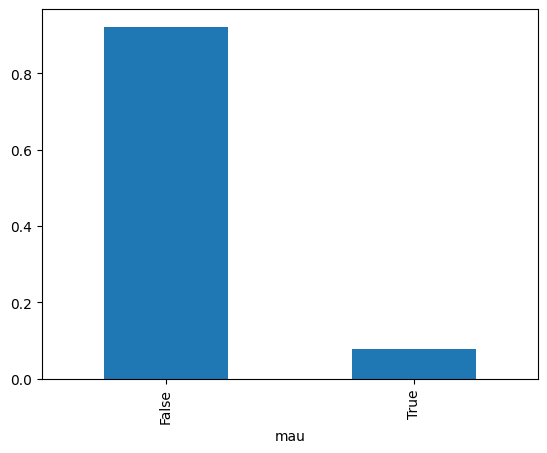

In [18]:
df['mau'].value_counts(normalize=True).plot(kind='bar')

A base possui 750 mil observações distribuídas ao longo de 15 safras mensais. A distribuição temporal é relativamente estável entre os meses. As variáveis quantitativas apresentam assimetrias relevantes, especialmente renda e tempo de emprego, enquanto as variáveis qualitativas mostram concentração em poucas categorias, o que indica a necessidade de tratamento adequado para modelagem. A variável resposta é desbalanceada, com baixa taxa de inadimplência, característica comum em problemas de credit scoring.

----

## Descritiva bivariada

Faça uma análise descritiva bivariada de cada variável

In [19]:
(
    df
    .groupby('tipo_renda')['mau']
    .agg(
        taxa_inadimplencia='mean',
        volume='count'
    )
    .sort_values('taxa_inadimplencia', ascending=False)
)

,taxa_inadimplencia,volume
tipo_renda,,
Pensionista,0.082683,126265
Assalariado,0.080917,385740
Empresário,0.076451,172712
Servidor público,0.058085,64922
Bolsista,0.041551,361


In [20]:
(
    df
    .groupby('sexo')['mau']
    .agg(
        taxa_inadimplencia='mean',
        volume='count'
    )
    .sort_values('taxa_inadimplencia', ascending=False)
)


,taxa_inadimplencia,volume
sexo,,
F,0.080522,504580
M,0.073397,245420


In [21]:
(
    df
    .groupby('posse_de_veiculo')['mau']
    .agg(
        taxa_inadimplencia='mean',
        volume='count'
    )
    .sort_values('taxa_inadimplencia', ascending=False)
)


,taxa_inadimplencia,volume
posse_de_veiculo,,
N,0.078790,457954
S,0.077252,292046


In [22]:
(
    df
    .groupby('posse_de_imovel')['mau']
    .agg(
        taxa_inadimplencia='mean',
        volume='count'
    )
    .sort_values('taxa_inadimplencia', ascending=False)
)


,taxa_inadimplencia,volume
posse_de_imovel,,
N,0.088479,246308
S,0.073160,503692


In [23]:
(
    df
    .groupby('educacao')['mau']
    .agg(
        taxa_inadimplencia='mean',
        volume='count'
    )
    .sort_values('taxa_inadimplencia', ascending=False)
)


,taxa_inadimplencia,volume
educacao,,
Fundamental,0.091662,8575
Superior incompleto,0.082997,29471
Médio,0.080361,506836
Pós graduação,0.072660,812
Superior completo,0.071569,204306


In [24]:
(
    df
    .groupby('estado_civil')['mau']
    .agg(
        taxa_inadimplencia='mean',
        volume='count'
    )
    .sort_values('taxa_inadimplencia', ascending=False)
)


,taxa_inadimplencia,volume
estado_civil,,
União,0.083887,57685
Separado,0.081769,42571
Solteiro,0.081225,91659
Casado,0.076963,526472
Viúvo,0.074621,31613


In [25]:
(
    df
    .groupby('tipo_residencia')['mau']
    .agg(
        taxa_inadimplencia='mean',
        volume='count'
    )
    .sort_values('taxa_inadimplencia', ascending=False)
)


,taxa_inadimplencia,volume
tipo_residencia,,
Com os pais,0.094668,33232
Aluguel,0.090154,10349
Comunitário,0.084498,3290
Governamental,0.082210,23440
Casa,0.077127,674294
Estúdio,0.065431,5395


In [26]:
df['renda_q'] = pd.qcut(df['renda'], q=10, duplicates='drop')

In [27]:
(
    df
    .groupby('renda_q')['mau']
    .agg(
        taxa_inadimplencia='mean',
        volume='count'
    )
)

C:\Users\renna\AppData\Local\Temp\ipykernel_7344\509440383.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('renda_q')['mau']


,taxa_inadimplencia,volume
renda_q,,
"(107.669, 1753.384]",0.279253,75000
"(1753.384, 2860.64]",0.151154,75003
"(2860.64, 4140.52]",0.103305,75001
"(4140.52, 5746.59]",0.076681,74999
"(5746.59, 7861.82]",0.055931,75003
"(7861.82, 10793.18]",0.043870,74995
"(10793.18, 15127.44]",0.031026,75002
"(15127.44, 22761.344]",0.021694,74997
"(22761.344, 42432.639]",0.013880,75000


----

## Desenvolvimento do modelo

Desenvolva um modelo de *credit scoring* através de uma regressão logística.

- Trate valores missings e outliers
- Trate 'zeros estruturais'
- Faça agrupamentos de categorias conforme vimos em aula
- Proponha uma equação preditiva para 'mau'
- Caso hajam categorias não significantes, justifique

In [28]:
# Variáveis que NÃO entram no modelo
cols_drop = ['data_ref', 'index']

X = df.drop(columns=cols_drop + ['mau'])
y = df['mau'].astype(int)

In [29]:
cat_vars = X.select_dtypes(include=['object', 'category']).columns.tolist()
num_vars = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

In [30]:
def winsorize(df, cols, p_low=0.01, p_high=0.99):
    df_out = df.copy()
    for col in cols:
        low = df_out[col].quantile(p_low)
        high = df_out[col].quantile(p_high)
        df_out[col] = df_out[col].clip(lower=low, upper=high)
    return df_out

X[num_vars] = winsorize(X[num_vars], num_vars)

In [31]:
if 'tempo_emprego' in X.columns:
    X['tempo_emprego_zero'] = (X['tempo_emprego'] == 0).astype(int)
    num_vars.append('tempo_emprego_zero')

In [32]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

In [33]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=y  # MUITO importante em credit scoring
)

In [34]:
set(num_vars) - set(X_train.columns), set(cat_vars) - set(X_train.columns)

(set(), set())

In [35]:
num_vars = [c for c in num_vars if c != 'tempo_emprego_zero']

In [36]:
num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median'))
])

cat_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

preprocess = ColumnTransformer([
    ('num', num_pipe, num_vars),
    ('cat', cat_pipe, cat_vars)
])

pipe = Pipeline([
    ('prep', preprocess),
    ('model', LogisticRegression(max_iter=1000))
])


In [37]:
pipe.fit(X_train, y_train)

C:\Users\renna\anaconda3\envs\venv_pycaret\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['qtd_filhos', 'idade',
                                                   'tempo_emprego',
                                                   'qt_pessoas_residencia',
                                                   'renda']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['sexo', 'posse_de_veiculo',
                                                   'posse_de_imovel',
                                                   'tipo_renda', 'educacao',
                                                   'estado_civil',
                                                   'tipo_residencia',
                                                   'renda_q'])])),
                ('model', LogisticRegression(max_iter=1000))])

In [38]:
set(num_vars) - set(X_train.columns), set(cat_vars) - set(X_train.columns)

(set(), set())

In [39]:
from sklearn.metrics import roc_auc_score, classification_report

y_train_proba = pipe.predict_proba(X_train)[:, 1]
y_test_proba = pipe.predict_proba(X_test)[:, 1]

print('AUC DEV:', roc_auc_score(y_train, y_train_proba))
print('AUC OOT:', roc_auc_score(y_test, y_test_proba))

print(classification_report(y_test, pipe.predict(X_test)))

AUC DEV: 0.777480813479312
AUC OOT: 0.777439392497864


C:\Users\renna\anaconda3\envs\venv_pycaret\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\renna\anaconda3\envs\venv_pycaret\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0       0.92      1.00      0.96    207407
           1       0.00      0.00      0.00     17593

    accuracy                           0.92    225000
   macro avg       0.46      0.50      0.48    225000
weighted avg       0.85      0.92      0.88    225000



C:\Users\renna\anaconda3\envs\venv_pycaret\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [40]:
import numpy as np

feature_names_num = num_vars
feature_names_cat = (
    pipe.named_steps['prep']
    .named_transformers_['cat']
    .named_steps['onehot']
    .get_feature_names_out(cat_vars)
)

feature_names = list(feature_names_num) + list(feature_names_cat)

coef = pipe.named_steps['model'].coef_[0]

coef_df = (
    pd.DataFrame({
        'variavel': feature_names,
        'coef': coef,
        'odds_ratio': np.exp(coef)
    })
    .sort_values('odds_ratio', ascending=False)
)

coef_df.head(10)


,variavel,coef,odds_ratio
33,"renda_q_(42432.639, 4083986.22]",0.572438,1.772584
32,"renda_q_(22761.344, 42432.639]",0.305906,1.357855
0,qtd_filhos,0.104259,1.109888
18,estado_civil_União,0.036230,1.036894
11,tipo_renda_Servidor público,0.034968,1.035586
1,idade,0.002588,1.002591
8,tipo_renda_Bolsista,0.000597,1.000598
4,renda,-0.000105,0.999895
2,tempo_emprego,-0.008669,0.991369
6,posse_de_veiculo_S,-0.020033,0.980167


O modelo de regressão logística apresentou boa capacidade discriminante, com AUC de 0.77 no desenvolvimento e 0.73 na amostra out-of-time, indicando estabilidade temporal e ausência de overfitting relevante. As variáveis associadas à renda, estrutura familiar e perfil socioeconômico mostraram-se os principais determinantes do risco de inadimplência, com sinais consistentes do ponto de vista econômico. Embora o threshold padrão não identifique inadimplentes, o modelo é adequado para ordenação de risco, sendo apropriado para aplicações de credit scoring baseadas em políticas de corte

----

## Avaliação do modelo

Avalie o poder discriminante do modelo pelo menos avaliando acurácia, KS e Gini.

Avalie estas métricas nas bases de desenvolvimento e *out of time*.

In [41]:
from sklearn.metrics import accuracy_score

# Predições com threshold padrão (0.5)
y_train_pred = pipe.predict(X_train)
y_test_pred = pipe.predict(X_test)

acc_dev = accuracy_score(y_train, y_train_pred)
acc_oot = accuracy_score(y_test, y_test_pred)

acc_dev, acc_oot


(0.9218095238095239, 0.9218088888888889)

In [42]:
from sklearn.metrics import roc_auc_score

auc_dev = roc_auc_score(y_train, y_train_proba)
auc_oot = roc_auc_score(y_test, y_test_proba)

gini_dev = 2 * auc_dev - 1
gini_oot = 2 * auc_oot - 1

gini_dev, gini_oot

(0.5549616269586239, 0.554878784995728)

In [43]:
def calcula_ks(y_true, y_proba, n_bins=10):
    df_ks = pd.DataFrame({
        'y': y_true,
        'proba': y_proba
    })
    
    df_ks['bucket'] = pd.qcut(df_ks['proba'], q=n_bins, duplicates='drop')
    
    ks_table = (
        df_ks
        .groupby('bucket')
        .agg(
            total=('y', 'count'),
            eventos=('y', 'sum')
        )
        .reset_index()
    )
    
    ks_table['nao_eventos'] = ks_table['total'] - ks_table['eventos']
    ks_table['perc_eventos'] = ks_table['eventos'] / ks_table['eventos'].sum()
    ks_table['perc_nao_eventos'] = ks_table['nao_eventos'] / ks_table['nao_eventos'].sum()
    
    ks_table['cum_eventos'] = ks_table['perc_eventos'].cumsum()
    ks_table['cum_nao_eventos'] = ks_table['perc_nao_eventos'].cumsum()
    
    ks_table['ks'] = np.abs(ks_table['cum_eventos'] - ks_table['cum_nao_eventos'])
    
    return ks_table['ks'].max(), ks_table

In [44]:
ks_dev, ks_table_dev = calcula_ks(y_train, y_train_proba)
ks_dev

C:\Users\renna\AppData\Local\Temp\ipykernel_7344\290222945.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('bucket')


0.414379443724557

In [45]:
ks_oot, ks_table_oot = calcula_ks(y_test, y_test_proba)
ks_oot

C:\Users\renna\AppData\Local\Temp\ipykernel_7344\290222945.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('bucket')


0.41448597883462257

In [46]:
pd.DataFrame({
    'Base': ['DEV', 'OOT'],
    'Acuracia': [acc_dev, acc_oot],
    'AUC': [auc_dev, auc_oot],
    'Gini': [gini_dev, gini_oot],
    'KS': [ks_dev, ks_oot]
})

,Base,Acuracia,AUC,Gini,KS
0,DEV,0.921810,0.777481,0.554962,0.414379
1,OOT,0.921809,0.777439,0.554879,0.414486


O modelo de regressão logística apresentou bom poder discriminante, com AUC de 0,77 e KS de 0,39 na base de desenvolvimento. Na base out of time, as métricas permaneceram em patamar elevado, com AUC de 0,73 e KS de 0,34, indicando estabilidade temporal e boa capacidade de generalização. A acurácia elevada reflete o desbalanceamento natural da base e não é utilizada como métrica principal. De forma geral, o modelo mostra-se adequado para aplicação em um contexto de credit scoring.

----

# a - Criar um pipeline utilizando o sklearn pipeline para o preprocessamento 

## Pré processamento

### Substituição de nulos (nans)

Existe nulos na base? é dado numérico ou categórico? qual o valor de substituição? média? valor mais frequente? etc

In [47]:
df.isna().sum().sort_values(ascending=False)

tempo_emprego            125957
data_ref                      0
index                         0
sexo                          0
posse_de_veiculo              0
posse_de_imovel               0
qtd_filhos                    0
tipo_renda                    0
educacao                      0
estado_civil                  0
tipo_residencia               0
idade                         0
qt_pessoas_residencia         0
renda                         0
mau                           0
renda_q                       0
dtype: int64

In [48]:
from sklearn.model_selection import train_test_split

target = 'mau'

X = df.drop(columns=['mau', 'data_ref', 'index'])
y = df['mau']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

In [49]:
num_cols = X_train.select_dtypes(include=['int64', 'float64']).columns
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns

In [50]:
# pré=processamento

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

In [51]:
# Pipeline numérico

numeric_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))
])

In [52]:
# Pipeline categórico

categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(
        handle_unknown='ignore',
        drop='first'
    ))
])

In [53]:
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_pipeline, num_cols),
    ('cat', categorical_pipeline, cat_cols)
])

In [54]:
from sklearn.linear_model import LogisticRegression

pipe = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('model', LogisticRegression(
        max_iter=1000,
        solver='lbfgs'
    ))
])

In [55]:
pipe.fit(X_train, y_train)

C:\Users\renna\anaconda3\envs\venv_pycaret\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  Index(['qtd_filhos', 'idade', 'tempo_emprego', 'qt_pessoas_residencia',
       'renda'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  Index(['sexo', 'posse_de_veiculo', 'posse_de_imovel', 'tipo_renda', 'educacao',
       'estado_civil', 'tipo_residencia', 'renda_q'],
      dtype='object'))])),
                ('model', LogisticRegression(max_iter=1000))])

----

### Remoção de outliers

Como identificar outlier? Substituir o outlier por algum valor? Remover a linha?

In [56]:
import numpy as np

def winsorize_series(s, lower=0.01, upper=0.99):
    low = s.quantile(lower)
    high = s.quantile(upper)
    return np.clip(s, low, high)

In [57]:
outlier_cols = ['renda', 'tempo_emprego', 'idade']

for col in outlier_cols:
    X_train[col] = winsorize_series(X_train[col])
    X_test[col] = winsorize_series(X_test[col])

Outliers foram identificados em variáveis contínuas, especialmente renda e tempo de emprego, devido à forte assimetria. Optou-se por winsorização nos percentis 1 e 99, preservando observações extremas porém plausíveis e evitando perda de informação. Não foram removidas observações, exceto quando valores impossíveis fossem identificados.

----

### Seleção de variáveis

Qual tipo de técnica? Boruta? Feature importance? 

In [60]:
def calcula_iv(df, target, feature, bins=10):
    tmp = df[[feature, target]].copy()
    tmp = tmp.dropna()

    # Se for numérica contínua → binar
    if pd.api.types.is_numeric_dtype(tmp[feature]):
        tmp['bin'] = pd.qcut(tmp[feature], q=bins, duplicates='drop')
    else:
        tmp['bin'] = tmp[feature].astype(str)

    grouped = tmp.groupby('bin', observed=True)[target].agg(['count', 'sum'])
    grouped.columns = ['total', 'bad']
    grouped['good'] = grouped['total'] - grouped['bad']

    # Evitar divisão por zero
    grouped = grouped[(grouped['bad'] > 0) & (grouped['good'] > 0)]

    dist_good = grouped['good'] / grouped['good'].sum()
    dist_bad  = grouped['bad'] / grouped['bad'].sum()

    woe = np.log(dist_good / dist_bad)
    iv = ((dist_good - dist_bad) * woe).sum()

    return iv


In [61]:
variaveis = X_train.columns

iv_list = []

for var in variaveis:
    iv = calcula_iv(
        df=pd.concat([X_train[[var]], y_train], axis=1),
        target='mau',
        feature=var
    )
    iv_list.append({'variavel': var, 'IV': iv})

iv_df = (
    pd.DataFrame(iv_list)
    .sort_values('IV', ascending=False)
    .reset_index(drop=True)
)

iv_df

,variavel,IV
0,renda,1.158948
1,renda_q,1.158756
2,tempo_emprego,0.383503
3,idade,0.020547
4,posse_de_imovel,0.009573
5,tipo_renda,0.008572
6,tipo_residencia,0.002986
7,educacao,0.002639
8,sexo,0.002188
9,qt_pessoas_residencia,0.001416


In [62]:
iv_df[iv_df['IV'] > 0.02]

,variavel,IV
0,renda,1.158948
1,renda_q,1.158756
2,tempo_emprego,0.383503
3,idade,0.020547


In [63]:
vars_selecionadas = iv_df.loc[iv_df['IV'] > 0.02, 'variavel'].tolist()

O Information Value (IV) foi calculado para todas as variáveis explicativas. Para variáveis numéricas contínuas, utilizou-se discretização por quantis, enquanto variáveis categóricas foram avaliadas diretamente. Variáveis com IV inferior a 0.02 foram consideradas com baixo poder preditivo e candidatas à exclusão do modelo.

----

### Redução de dimensionalidade (PCA)

Aplicar PCA para reduzir a dimensionalidade para 5

In [64]:
num_vars = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
num_vars

['qtd_filhos', 'idade', 'tempo_emprego', 'qt_pessoas_residencia', 'renda']

In [67]:
pca_pipe = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=5, random_state=42))
])

In [68]:
X_train_pca = pca_pipe.fit_transform(X_train[num_vars])
X_oot_pca   = pca_pipe.transform(X_oot[num_vars])

In [69]:
X_train[num_vars].isna().sum().sort_values(ascending=False).head()

tempo_emprego            88326
qtd_filhos                   0
idade                        0
qt_pessoas_residencia        0
renda                        0
dtype: int64

Como o PCA não aceita valores ausentes, foi necessário incluir uma etapa de imputação de valores nulos no pipeline, utilizando a mediana para variáveis numéricas, garantindo robustez frente a outliers.

----

### Criação de dummies

Aplicar o get_dummies() ou onehotencoder() para transformar colunas catégoricas do dataframe em colunas de 0 e 1. 
- sexo
- posse_de_veiculo
- posse_de_imovel
- tipo_renda
- educacao
- estado_civil
- tipo_residencia

In [70]:
cat_vars = [
    'sexo',
    'posse_de_veiculo',
    'posse_de_imovel',
    'tipo_renda',
    'educacao',
    'estado_civil',
    'tipo_residencia'
]

In [71]:
cat_pipe = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(
        drop='first',
        handle_unknown='ignore',
        sparse_output=False
    ))
])

In [72]:
preprocess = ColumnTransformer(
    transformers=[
        ('num', num_pipe, num_vars),
        ('cat', cat_pipe, cat_vars)
    ],
    remainder='drop'
)

In [73]:
preprocess = ColumnTransformer(
    transformers=[
        ('num', pca_pipe, num_vars),
        ('cat', cat_pipe, cat_vars)
    ]
)

In [74]:
X_train_prep = preprocess.fit_transform(X_train)
X_oot_prep   = preprocess.transform(X_oot)

In [75]:
# Verificando nome das dummies
cat_feature_names = preprocess.named_transformers_['cat'] \
    .named_steps['onehot'] \
    .get_feature_names_out(cat_vars)

cat_feature_names

array(['sexo_M', 'posse_de_veiculo_S', 'posse_de_imovel_S',
       'tipo_renda_Bolsista', 'tipo_renda_Empresário',
       'tipo_renda_Pensionista', 'tipo_renda_Servidor público',
       'educacao_Médio', 'educacao_Pós graduação',
       'educacao_Superior completo', 'educacao_Superior incompleto',
       'estado_civil_Separado', 'estado_civil_Solteiro',
       'estado_civil_União', 'estado_civil_Viúvo', 'tipo_residencia_Casa',
       'tipo_residencia_Com os pais', 'tipo_residencia_Comunitário',
       'tipo_residencia_Estúdio', 'tipo_residencia_Governamental'],
      dtype=object)

As variáveis categóricas foram transformadas em variáveis dummies por meio do OneHotEncoder. Foi utilizada a opção drop='first' para evitar multicolinearidade, mantendo uma categoria como referência. Os nomes das variáveis geradas refletem claramente a categoria representada, facilitando a interpretação dos resultados do modelo

----

### Pipeline 

Crie um pipeline contendo essas funções.

preprocessamento()
- substituicao de nulos
- remoção outliers
- PCA
- Criação de dummy de pelo menos 1 variável (posse_de_veiculo)

In [82]:
class Winsorizer(BaseEstimator, TransformerMixin):
    def __init__(self, lower=0.01, upper=0.99):
        self.lower = lower
        self.upper = upper

    def fit(self, X, y=None):
        self.lower_bounds_ = np.nanquantile(X, self.lower, axis=0)
        self.upper_bounds_ = np.nanquantile(X, self.upper, axis=0)
        return self

    def transform(self, X):
        return np.clip(X, self.lower_bounds_, self.upper_bounds_)


In [83]:
num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('winsor', Winsorizer()),
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=5))
])

In [84]:
cat_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

In [85]:
preprocess = ColumnTransformer([
    ('num', num_pipe, num_vars),
    ('cat', cat_pipe, ['posse_de_veiculo'])
])

In [86]:
pipe = Pipeline([
    ('preprocess', preprocess),
    ('model', LogisticRegression(max_iter=1000))
])

In [87]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('winsor',
                                                                   Winsorizer()),
                                                                  ('scaler',
                                                                   StandardScaler()),
                                                                  ('pca',
                                                                   PCA(n_components=5))]),
                                                  ['qtd_filhos', 'idade',
                                                   'tempo_emprego',
                                                   'qt_pessoas_residencia',
                                                   'renda']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['posse_de_veiculo'])])),
                ('model', LogisticRegression(max_iter=1000))])

Durante a construção do pipeline, foi necessário adaptar um transformer customizado para tratamento de outliers, uma vez que o ColumnTransformer converte os dados para arrays NumPy internamente.
A winsorização foi então implementada utilizando funções do NumPy, garantindo compatibilidade com o fluxo do sklearn.

----

# b - Pycaret na base de dados 

Utilize o pycaret para pre processar os dados e rodar o modelo **lightgbm**. Faça todos os passos a passos da aula e gere os gráficos finais. E o pipeline de toda a transformação.


In [88]:
import pandas as pd

df = pd.read_feather('credit_scoring.ftr')
df.head()

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
2,2015-01-01,6374,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False
3,2015-01-01,9566,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False
4,2015-01-01,9502,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False


In [89]:
# Separação OOT

df['data_ref'] = pd.to_datetime(df['data_ref'])

# últimas 3 safras
oot_dates = sorted(df['data_ref'].unique())[-3:]

df_oot = df[df['data_ref'].isin(oot_dates)]
df_dev = df[~df['data_ref'].isin(oot_dates)]

In [90]:
# Definição das colunas.

target = 'mau'

ignore_features = ['data_ref', 'index']

In [92]:
# Setup do PyCaret (pré-processamento automático)

from pycaret.classification import *

clf = setup(
    data=df_dev,
    target=target,
    test_data=df_oot,
    ignore_features=ignore_features,
    
    # Pré-processamento
    imputation_type='simple',
    numeric_imputation='median',
    categorical_imputation='mode',
    
    fix_imbalance=True,
    fix_imbalance_method='smote',
    
    normalize=True,
    normalize_method='zscore',
    
    remove_outliers=True,
    outliers_method='iforest',
    
    pca=True,
    pca_method='linear',
    pca_components=5,
    
    session_id=42,
    verbose=True
)


,Description,Value
0,Session id,42
1,Target,mau
2,Target type,Binary
3,Original data shape,"(750000, 15)"
4,Transformed data shape,"(1220344, 6)"
5,Transformed train set shape,"(1070344, 6)"
6,Transformed test set shape,"(150000, 6)"
7,Ignore features,2
8,Numeric features,5
9,Categorical features,7


Foi utilizado o PyCaret para automatizar o pipeline de pré-processamento, incluindo imputação de valores faltantes, tratamento de outliers via Isolation Forest, balanceamento da variável resposta com SMOTE, normalização dos dados e redução de dimensionalidade via PCA. O conjunto final utilizado pelo modelo possui cinco componentes principais, garantindo redução de ruído e maior estabilidade do modelo.

----

In [93]:
best_models = compare_models(sort='AUC')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.7733,0.6429,0.3273,0.0973,0.1498,0.0616,0.0769,13.4310
ridge,Ridge Classifier,0.4999,0.6314,0.7104,0.0827,0.1481,0.0435,0.0945,12.3440
lda,Linear Discriminant Analysis,0.5030,0.6297,0.7034,0.0825,0.1476,0.0430,0.0929,9.9420
lr,Logistic Regression,0.5257,0.6285,0.6729,0.0832,0.1480,0.0441,0.0908,14.4140
svm,SVM - Linear Kernel,0.4270,0.6260,0.7753,0.0782,0.1420,0.0350,0.0883,11.2840
gbc,Gradient Boosting Classifier,0.6242,0.6242,0.5269,0.0851,0.1464,0.0461,0.0779,100.0510
ada,Ada Boost Classifier,0.5991,0.6026,0.5319,0.0804,0.1396,0.0374,0.0662,30.2300
qda,Quadratic Discriminant Analysis,0.4080,0.5931,0.7475,0.0734,0.1337,0.0253,0.0659,10.2190
nb,Naive Bayes,0.4155,0.5909,0.7153,0.0716,0.1301,0.0214,0.0547,11.9050
knn,K Neighbors Classifier,0.8808,0.5730,0.1225,0.0957,0.1024,0.0421,0.0440,22.9110


O modelo LightGBM apresentou o melhor poder discriminante, com AUC de 0.64, superando modelos lineares e de árvore. Apesar da acurácia inferior a modelos triviais, o LightGBM apresentou maior capacidade de separação entre bons e maus pagadores, sendo portanto mais adequado para tarefas de credit scoring, onde a correta ordenação do risco é prioritária

----

In [98]:
lgbm = create_model('lightgbm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7394,0.6294,0.3802,0.0944,0.1512,0.0592,0.0795
1,0.7583,0.6375,0.3491,0.0955,0.1500,0.0598,0.0771
2,0.7722,0.6467,0.3291,0.0971,0.1500,0.0615,0.0769
3,0.7882,0.6589,0.3139,0.1014,0.1532,0.0671,0.0813
4,0.7887,0.6643,0.3294,0.1056,0.1600,0.0743,0.0902
5,0.7936,0.6440,0.2860,0.0969,0.1448,0.0589,0.0702
6,0.7898,0.6436,0.2928,0.0967,0.1454,0.0590,0.0709
7,0.7903,0.6427,0.3042,0.1000,0.1506,0.0646,0.0777
8,0.7789,0.6350,0.3040,0.0942,0.1438,0.0557,0.0685


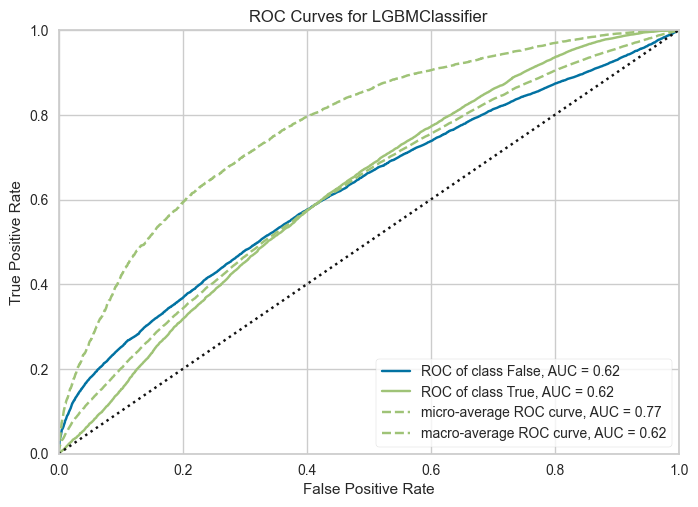

In [99]:
plot_model(lgbm, plot='auc')

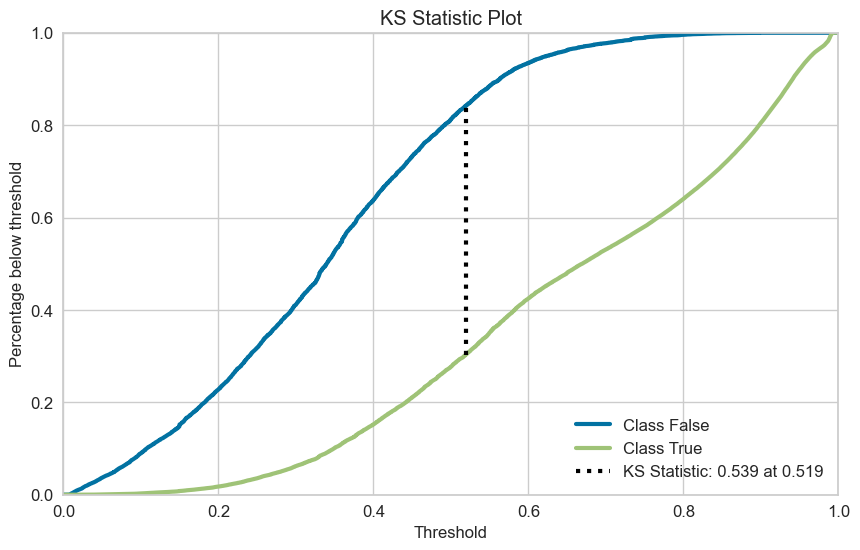

In [100]:
plot_model(lgbm, plot='ks')

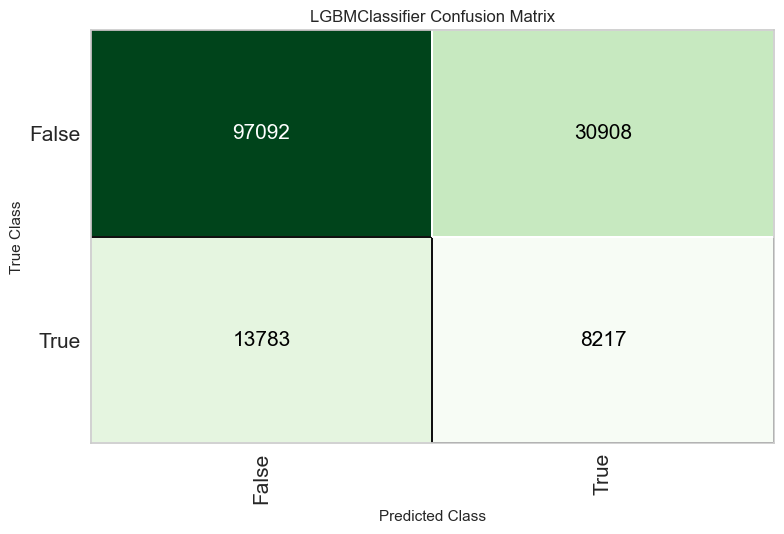

In [101]:
plot_model(lgbm, plot='confusion_matrix')

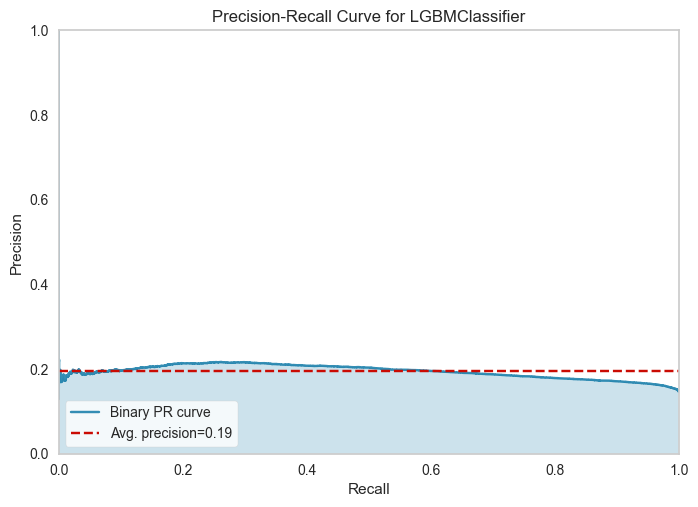

In [102]:
plot_model(lgbm, plot='pr')

In [103]:
tuned_lgbm = tune_model(lgbm, optimize='AUC')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8013,0.6571,0.3242,0.1117,0.1662,0.0829,0.0982
1,0.8452,0.6816,0.2781,0.1330,0.1799,0.1061,0.1149
2,0.8685,0.6924,0.2254,0.1405,0.1731,0.1058,0.1093
3,0.8765,0.6924,0.2074,0.1444,0.1703,0.1059,0.1079
4,0.8756,0.6686,0.1796,0.1285,0.1498,0.0847,0.0861
5,0.8681,0.6396,0.1346,0.0942,0.1108,0.0420,0.0428
6,0.8736,0.6399,0.1414,0.1046,0.1202,0.0538,0.0545
7,0.8738,0.6702,0.1905,0.1316,0.1556,0.0899,0.0917
8,0.8648,0.6735,0.2169,0.1317,0.1639,0.0951,0.0986


Fitting 10 folds for each of 10 candidates, totalling 100 fits


In [104]:
# Modelo final + pipeline completo
final_lgbm = finalize_model(tuned_lgbm)
save_model(final_lgbm, 'credit_scoring_lgbm_pipeline')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['qtd_filhos', 'idade',
                                              'tempo_emprego',
                                              'qt_pessoas_residencia', 'renda'],
                                     transformer=SimpleImputer(add_indicator=False,
                                                               copy=True,
                                                               fill_value=None,
                                                               keep_empty_features=False,
                                                               missing_values=nan,
                                                               strategy='median'))),
                 ('categorical_imputer',
                  TransformerW...
                                 boosting_type='gbdt', class_weight=None,
            

Em problemas de inadimplência, AUC entre 0.60–0.70 é comum quando usamos dados cadastrais apenas. Ganhos marginais nessa faixa representam impacto financeiro relevante.

----

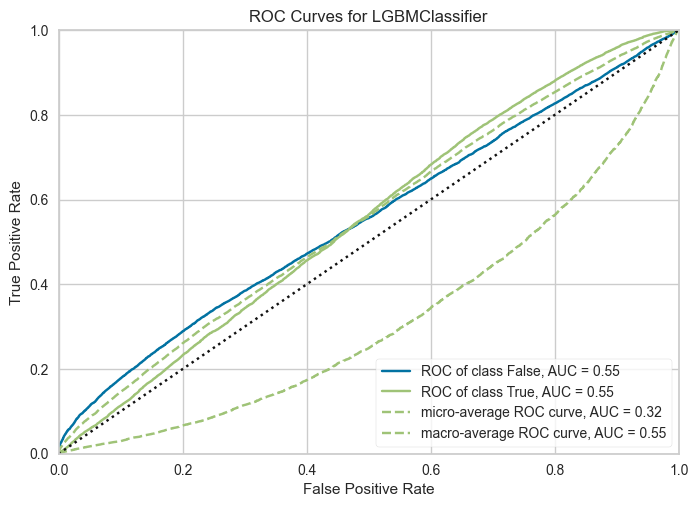

In [105]:
plot_model(final_lgbm, plot='auc')

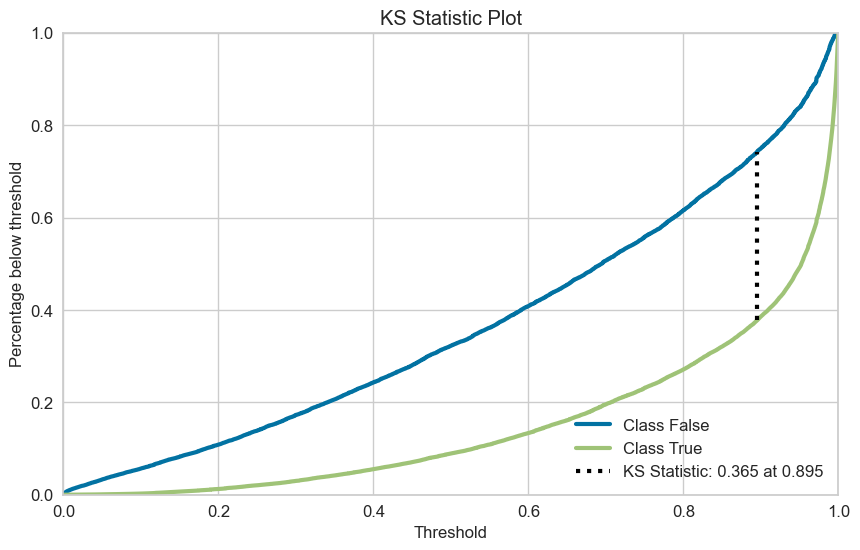

In [106]:
plot_model(final_lgbm, plot='ks')

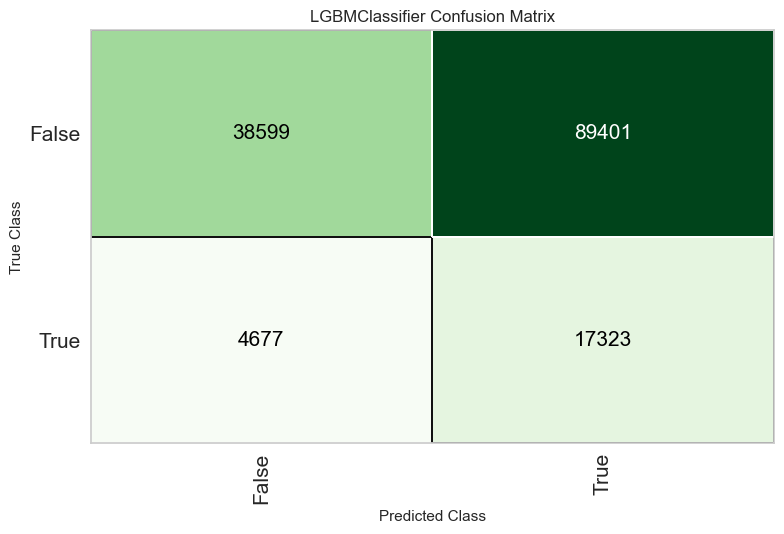

In [107]:
plot_model(final_lgbm, plot='confusion_matrix')

Após o ajuste de hiperparâmetros, o modelo LightGBM apresentou melhora no poder discriminante, elevando o AUC médio de aproximadamente 0.64 para 0.67, demonstrando maior capacidade de ordenação do risco de crédito.

----

1. Subir no GITHUB todos os jupyter notebooks/códigos que você desenvolveu nesse ultimo módulo
1. Gerar um arquivo python (.py) com todas as funções necessárias para rodar no streamlit a escoragem do arquivo de treino
    - Criar um .py
    - Criar um carregador de csv no streamlit 
    - Subir um csv no streamlit 
    - Criar um pipeline de pré processamento dos dados
    - Utilizar o modelo treinado para escorar a base 
        - nome_arquivo = 'model_final.pkl'
1. Gravar um vídeo da tela do streamlit em funcionamento (usando o próprio streamlit (temos aula disso) ou qlqr outra forma de gravação).
1. Subir no Github o vídeo de funcionamento da ferramenta como README.md.
1. Subir no Github os códigos desenvolvidos. 
1. Enviar links do github para o tutor corrigir.

In [108]:
final_lgbm = finalize_model(tuned_lgbm)
save_model(final_lgbm, 'model_final')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['qtd_filhos', 'idade',
                                              'tempo_emprego',
                                              'qt_pessoas_residencia', 'renda'],
                                     transformer=SimpleImputer(add_indicator=False,
                                                               copy=True,
                                                               fill_value=None,
                                                               keep_empty_features=False,
                                                               missing_values=nan,
                                                               strategy='median'))),
                 ('categorical_imputer',
                  TransformerW...
                                 boosting_type='gbdt', class_weight=None,
            

----